# Installation

In [1]:
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.2 MB/s eta 0:00:00


# Vérification avant de commencer

In [2]:
import ultralytics

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
ultralytics.checks()

Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.1/112.6 GB disk)


Visualisation des ressources et utilisation GPU

In [4]:
!nvidia-smi

Tue May  6 07:07:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Vérification disponibilité GPU

In [5]:
import torch
print("GPU disponible :", torch.cuda.is_available())

GPU disponible : True


# Préparation du dataset

In [6]:
!unzip -q /content/data.zip -d /content/custom_data_raw

## Organisation à avoir

```
custom_data/
├── images/
│   ├── train/
│   └── val/
├── labels/
│   ├── train/
│   └── val/


## Réorganisation du dataset

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Répertoire d'origine pour les images et annotations
raw_data_path_images = "/content/custom_data_raw/images"  # Images sont dans ce dossier
raw_data_path_labels = "/content/custom_data_raw/obj_train_data"  # Annotations dans ce dossier

# Obtenir toutes les images (jpg/png) présentes dans le dossier "images"
images = [f for f in os.listdir(raw_data_path_images) if f.endswith(('.jpg', '.png'))]

# Split train/val (80% train, 20% val)
train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

# Création des dossiers cible pour images et labels
base_path = "/content/custom_data"


os.makedirs(base_path + "/images/train", exist_ok=True)
os.makedirs(base_path + "/images/val", exist_ok=True)
os.makedirs(base_path + "/labels/train", exist_ok=True)
os.makedirs(base_path + "/labels/val", exist_ok=True)

def move_data(image_list, split):
    for img_name in image_list:
        # Déplacer l'image vers le bon dossier
        src_img = os.path.join(raw_data_path_images, img_name)
        dst_img = os.path.join(base_path, f"images/{split}", img_name)
        shutil.copy(src_img, dst_img)

        # Vérifier et déplacer l'annotation .txt correspondante
        txt_name = img_name.rsplit('.', 1)[0] + '.txt'
        txt_src = os.path.join(raw_data_path_labels, txt_name)
        txt_dst = os.path.join(base_path, f"labels/{split}", txt_name)

        if os.path.exists(txt_src):
            shutil.copy(txt_src, txt_dst)
        else:
            print(f"Pas d'annotation pour {img_name}")

# Appliquer le déplacement aux deux splits : train et val
move_data(train_imgs, "train")
move_data(val_imgs, "val")


# Augmentation


In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import cv2
import os

# === PARAMÈTRES ===
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=20, p=0.3),
    A.RandomGamma(p=0.3),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.4)
])

# Tu appliques l'augmentation uniquement sur le dossier d'entraînement
augmented_path = "/content/custom_data_augmented/images/train"
augmented_label_path = "/content/custom_data_augmented/labels/train"
os.makedirs(augmented_path, exist_ok=True)
os.makedirs(augmented_label_path, exist_ok=True)

original_train_images_path = "/content/custom_data/images/train"
original_train_labels_path = "/content/custom_data/labels/train"

# Copie les fichiers originaux
for img_file in tqdm(os.listdir(original_train_images_path), desc="Copie des images originales"):
    if not img_file.endswith(('.jpg', '.png')):
        continue
    img_path = os.path.join(original_train_images_path, img_file)
    label_path = os.path.join(original_train_labels_path, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))

    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    # Sauvegarde originale
    cv2.imwrite(os.path.join(augmented_path, img_file), img)
    shutil.copy(label_path, os.path.join(augmented_label_path, os.path.basename(label_path)))

    # Augmente 2 fois chaque image
    for i in range(2):
        augmented = augmentations(image=img)["image"]
        aug_img_name = img_file.replace('.', f'_aug{i}.')
        aug_lbl_name = img_file.replace('.jpg', f'_aug{i}.txt').replace('.png', f'_aug{i}.txt')

        cv2.imwrite(os.path.join(augmented_path, aug_img_name), augmented)
        shutil.copy(label_path, os.path.join(augmented_label_path, aug_lbl_name))

print("✅ Dataset augmenté.")


Copie des images originales: 100%|██████████| 28/28 [00:12<00:00,  2.22it/s]

✅ Dataset augmenté.


In [9]:
# Copie val original sans modification
original_val_images_path = "/content/custom_data/images/val"
original_val_labels_path = "/content/custom_data/labels/val"

val_img_out_dir = "/content/custom_data_augmented/images/val"
val_lbl_out_dir = "/content/custom_data_augmented/labels/val"

os.makedirs(val_img_out_dir, exist_ok=True)
os.makedirs(val_lbl_out_dir, exist_ok=True)

for img_file in os.listdir(original_val_images_path):
    if not img_file.endswith(('.jpg', '.png')):
        continue

    img_src = os.path.join(original_val_images_path, img_file)
    lbl_src = os.path.join(original_val_labels_path, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))

    img_dst = os.path.join(val_img_out_dir, img_file)
    lbl_dst = os.path.join(val_lbl_out_dir, os.path.basename(lbl_src))

    shutil.copy(img_src, img_dst)
    shutil.copy(lbl_src, lbl_dst)

print("✅ Validation copiée sans modification.")


✅ Validation copiée sans modification.


# Split des images du dataset

In [10]:
import os
import cv2
import shutil

# === PARAMÈTRES ===
# input_root = "/content/custom_data"
input_root = "/content/custom_data_augmented"

output_root = "/content/split_custom_data"

base_split_path = "/content/split_custom_data"

tile_size = 320
overlap = 0

splits = ["train", "val"]

def yolo_to_bbox(x_center, y_center, w, h, img_w, img_h):
    x1 = int((x_center - w / 2) * img_w)
    y1 = int((y_center - h / 2) * img_h)
    x2 = int((x_center + w / 2) * img_w)
    y2 = int((y_center + h / 2) * img_h)
    return x1, y1, x2, y2

def bbox_to_yolo(x1, y1, x2, y2, tile_w, tile_h):
    x_center = (x1 + x2) / 2 / tile_w
    y_center = (y1 + y2) / 2 / tile_h
    w = (x2 - x1) / tile_w
    h = (y2 - y1) / tile_h
    return x_center, y_center, w, h

# Boucle sur train et val
for split in splits:
    input_img_dir = os.path.join(input_root, f"images/{split}")
    input_lbl_dir = os.path.join(input_root, f"labels/{split}")
    output_img_dir = os.path.join(output_root, f"images/{split}")
    output_lbl_dir = os.path.join(output_root, f"labels/{split}")

    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_lbl_dir, exist_ok=True)

    for filename in os.listdir(input_img_dir):
        if not filename.lower().endswith(('.jpg', '.png')):
            continue

        basename = os.path.splitext(filename)[0]
        img_path = os.path.join(input_img_dir, filename)
        label_path = os.path.join(input_lbl_dir, f"{basename}.txt")

        img = cv2.imread(img_path)
        img_h, img_w = img.shape[:2]

        annotations = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) == 5:
                        cls, xc, yc, w, h = map(float, parts)
                        annotations.append((cls, *yolo_to_bbox(xc, yc, w, h, img_w, img_h)))

        step = tile_size - overlap
        tile_id = 0

        for y in range(0, img_h, step):
            for x in range(0, img_w, step):
                tile = img[y:y + tile_size, x:x + tile_size]
                tile_h, tile_w = tile.shape[:2]

                if tile_h < tile_size or tile_w < tile_size:
                    continue

                tile_filename = f"{basename}_{tile_id}.jpg"
                label_filename = f"{basename}_{tile_id}.txt"
                tile_id += 1

                cv2.imwrite(os.path.join(output_img_dir, tile_filename), tile)

                new_annots = []
                for cls, x1, y1, x2, y2 in annotations:
                    if x1 >= x + tile_size or x2 <= x or y1 >= y + tile_size or y2 <= y:
                        continue

                    bx1 = max(0, x1 - x)
                    by1 = max(0, y1 - y)
                    bx2 = min(tile_size, x2 - x)
                    by2 = min(tile_size, y2 - y)

                    if bx2 - bx1 < 5 or by2 - by1 < 5:
                        continue

                    x_c, y_c, w, h = bbox_to_yolo(bx1, by1, bx2, by2, tile_size, tile_size)
                    new_annots.append(f"{int(cls)} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}")

                with open(os.path.join(output_lbl_dir, label_filename), "w") as f:
                    f.write("\n".join(new_annots))

    print(f"✅ Split terminé pour '{split}' — {len(os.listdir(output_img_dir))} tuiles générées")


✅ Split terminé pour 'train' — 6540 tuiles générées
✅ Split terminé pour 'val' — 532 tuiles générées


# Génération des YAML

Dynamique :

In [11]:
# Chemin vers le fichier obj.names exporté par CVAT (modifie si besoin)
obj_names_path = "/content/custom_data_raw/obj.names"

# Lire les noms de classes depuis obj.names
with open(obj_names_path, 'r') as f:
    class_names = [line.strip() for line in f if line.strip()]

# Générer le contenu du fichier YAML avec les augmentations de couleur
yaml_content = f"""
path: {base_split_path}
train: images/train
val: images/val
nc: {len(class_names)}
names: {class_names}
augment: True  # Activer l'augmentation des données
auto_augment: albumentations



# weights: [0.9, 0.1]  # Exemple de pondération si olive est trop présente
"""


# Écriture du fichier data.yaml
with open(f"{base_path}/data.yaml", "w") as f:
    f.write(yaml_content.strip())

with open(f"{base_split_path}/data.yaml", "w") as f:
    f.write(yaml_content.strip())

print(" Fichier data.yaml généré automatiquement :")
print(yaml_content)


 Fichier data.yaml généré automatiquement :

path: /content/split_custom_data
train: images/train
val: images/val
nc: 2
names: ['olive', 'potential_olive']
augment: True  # Activer l'augmentation des données
auto_augment: albumentations



# weights: [0.9, 0.1]  # Exemple de pondération si olive est trop présente



In [12]:
custom_train_cfg = """
# train_custom.yaml — Configuration d'entraînement pour YOLOv8

# Chemins
data: /content/split_custom_data/data.yaml
# model: yolov8m.pt
model: yolo11m.pt

# Entraînement
epochs: 50
batch: 16
imgsz: 320
# device: 0

# Hyperparamètres généraux
optimizer: SGD
lr0: 0.01
lrf: 0.01




# Augmentations géométriques
degrees: 00.0
translate: 0.0
scale: 0.5
shear: 0.0
perspective: 0.0
flipud: 0.0
fliplr: 0.5

# Augmentations de couleur (adapté olives/feuillage)
hsv_h: 0.02
hsv_s: 0.6
hsv_v: 0.5

# Avancées
mosaic: 0.3
mixup: 0.1
copy_paste: 0.6

# auto_augment: randaugment
auto_augment: albumentations

"""

# Écriture du fichier YAML
with open("/content/custom_data/train_custom.yaml", "w") as f:
    f.write(custom_train_cfg.strip())

print("✅ Fichier train_custom.yaml généré.")

with open(f"/content/split_custom_data/train_custom.yaml", "w") as f:
    f.write(custom_train_cfg.strip())

print("✅ Fichier train_custom.yaml généré.")


✅ Fichier train_custom.yaml généré.
✅ Fichier train_custom.yaml généré.


## Vérification des labels et autres

In [13]:
import os
from collections import Counter

# Dictionnaire des classes : adapte-le si jamais tu changes l'ordre ou les noms
class_names = {
    '0': 'olive',
    '1': 'potential_olive'
}

def analyze_labels(labels_dir):
    label_counts = Counter()

    for split in ['train', 'val']:
        dir_path = os.path.join(labels_dir, split)
        for file in os.listdir(dir_path):
            if file.endswith('.txt'):
                with open(os.path.join(dir_path, file), 'r') as f:
                    for line in f:
                        if line.strip():
                            class_id = line.strip().split()[0]
                            label_counts[class_id] += 1

    print(" Résumé des classes dans les annotations :\n")
    for class_id, count in label_counts.items():
        class_name = class_names.get(class_id, " Inconnu")
        print(f"Classe {class_id} ({class_name}) → {count} objets")

    # Alerte pour les classes non attendues
    for cid in label_counts:
        if cid not in class_names:
            print(f"\n ID inattendu détecté : {cid}")

# Appel de la fonction
analyze_labels(f"{base_split_path}/labels")


 Résumé des classes dans les annotations :

Classe 1 (potential_olive) → 335 objets
Classe 0 (olive) → 10103 objets


# Train

- Changer le nombre d'epochs : Avec seulement 6 images et un grand déséquilibre, 10 epochs peuvent ne pas être suffisants. Essaie d'augmenter le nombre d'epochs (par exemple, à 50 ou 100) pour donner au modèle plus de temps pour apprendre.

- Réduire le imgsz : La taille des images peut avoir un impact sur l'entraînement. Si les images sont petites (moins de détails), une taille de 320x320 ou 416x416 pourrait mieux fonctionner qu'une taille de 640x640, qui peut être plus difficile à traiter.

In [14]:
!yolo task=detect mode=train cfg={base_split_path}/train_custom.yaml

Overriding /usr/local/lib/python3.11/dist-packages/ultralytics/cfg/default.yaml with /content/split_custom_data/train_custom.yaml
WARNING ⚠️ 'mode' argument is missing. Valid modes are frozenset({'export', 'benchmark', 'val', 'predict', 'train', 'track'}). Using default 'mode=train'.
100% 38.8M/38.8M [00:00<00:00, 346MB/s]
Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=albumentations, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.6, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/split_custom_data/data.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=0.6, hsv_v=0.5, imgsz=320, int8=False, iou=0

In [ ]:
#yolo task=detect mode=train model=yolo11n.pt data={base_path}/data.yaml hyp={base_path}/hyp.yaml epochs=100 imgsz=640 device=0

In [15]:
import glob
from IPython.display import Image, display

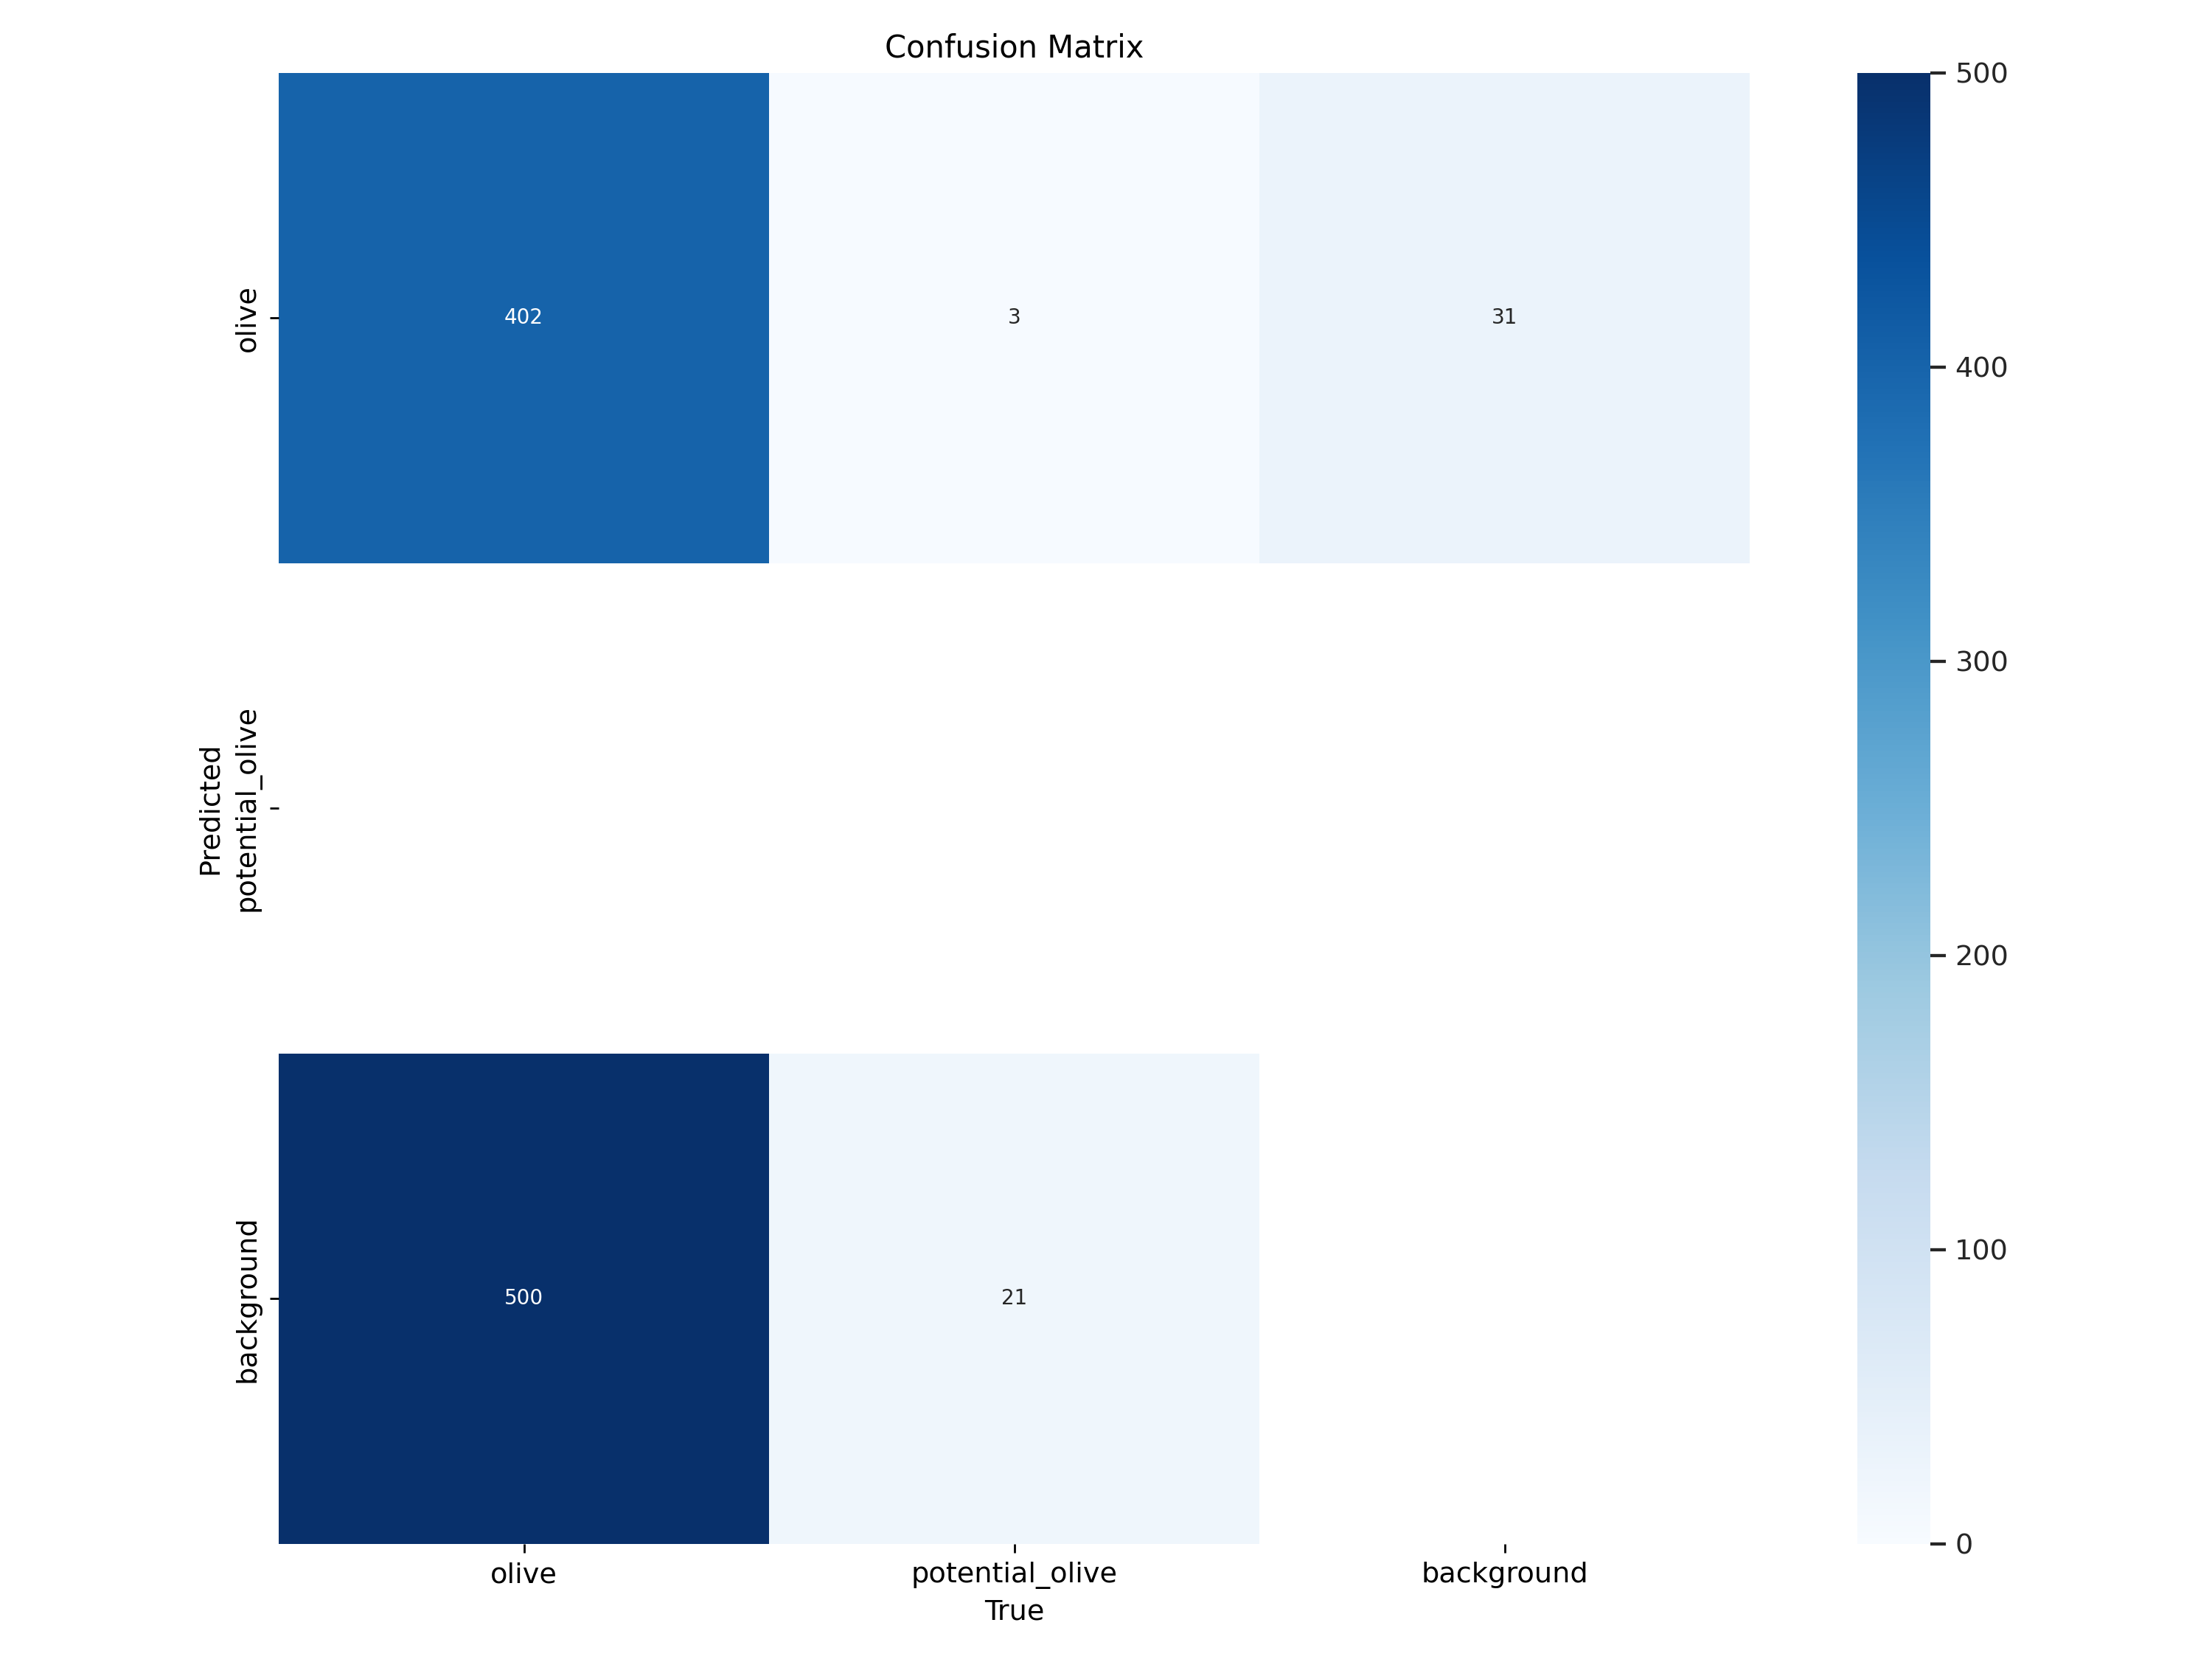

In [16]:
Image(filename='runs/detect/train/confusion_matrix.png', width=600)

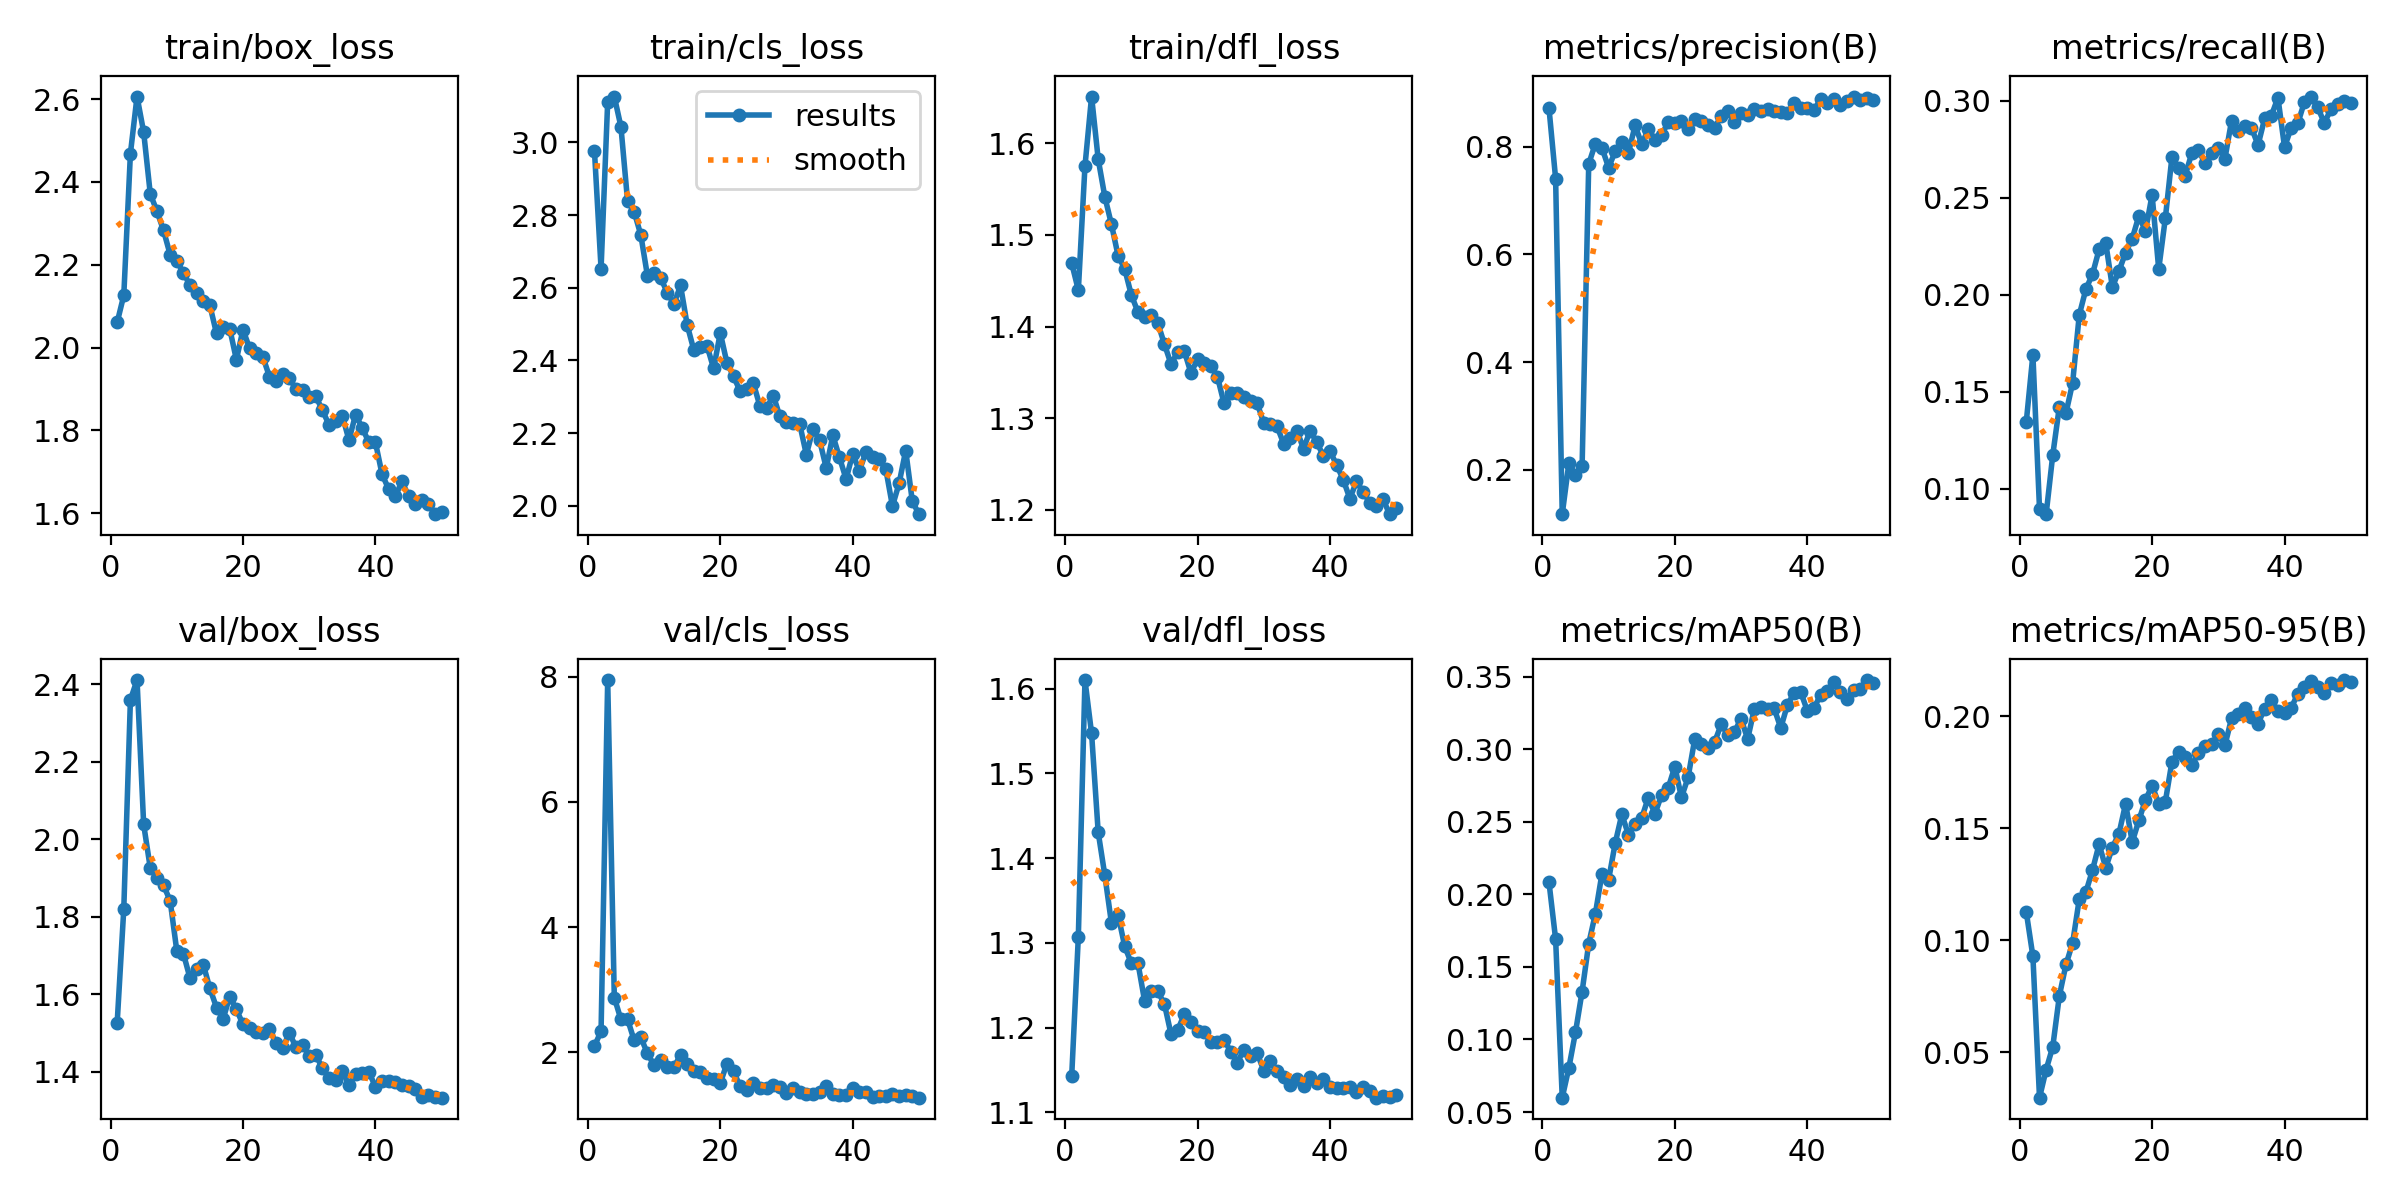

In [17]:
Image(filename='runs/detect/train/results.png', width=600)

# Validation

In [19]:
from ultralytics import YOLO

# Charger le modèle entraîné
model = YOLO("runs/detect/train/weights/best.pt")

# Évaluer sur le dataset de validation
metrics = model.val(data="/content/split_custom_data/data.yaml", split="val", verbose=False)

# Accès aux métriques par classe
names = model.names  # dict {class_id: name}
precision_per_class = metrics.box.p  # Précision par classe
recall_per_class = metrics.box.r  # Rappel par classe
map50_per_class = metrics.box.ap50  # mAP à IoU de 0.5 par classe
map_per_class = metrics.box.ap  # mAP à IoU de 0.5-0.95 par classe

# Exemple : récupérer les métriques de la classe "olive"
class_name = "olive"
class_id = list(names.values()).index(class_name)

print(f"Métriques pour la classe '{class_name}':")
print(f" - Précision : {precision_per_class[class_id]:.3f}")
print(f" - Rappel    : {recall_per_class[class_id]:.3f}")
print(f" - mAP@50    : {map50_per_class[class_id]:.3f}")
print(f" - mAP@50-95 : {map_per_class[class_id]:.3f}")


Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,031,574 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1104.4±545.6 MB/s, size: 38.6 KB)


val: Scanning /content/split_custom_data/labels/val.cache... 532 images, 282 backgrounds, 0 corrupt: 100%|██████████| 532/532 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  6.23it/s]


                   all        532        926      0.892        0.3      0.347      0.216
Speed: 0.3ms preprocess, 6.4ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val
Métriques pour la classe 'olive':
 - Précision : 0.783
 - Rappel    : 0.600
 - mAP@50    : 0.686
 - mAP@50-95 : 0.428


En modifiant conf

In [23]:
from ultralytics import YOLO
from pathlib import Path
import cv2
import os
from ultralytics.utils.metrics import bbox_iou

# 🔧 Paramètres
model_path = "runs/detect/train/weights/best.pt"
data_path = "/content/split_custom_data/data.yaml"
val_images_dir = "/content/split_custom_data/images/val"
conf_threshold = 0.05  # 🔁 MODIFIE ici le seuil de confiance
target_class = "olive"
iou_threshold = 0.5  # pour comptage TP/FN

# 📦 Charger modèle + noms des classes
model = YOLO(model_path)
names = model.names
target_id = list(names.values()).index(target_class)

# 📂 Liste des fichiers image de validation
image_paths = list(Path(val_images_dir).rglob("*.jpg")) + list(Path(val_images_dir).rglob("*.png"))

# 🔢 Compteurs
TP, FP, FN = 0, 0, 0

# 🔍 Parcourir les images
import torch

# 🔍 Parcourir les images
for img_path in image_paths:
    results = model.predict(source=str(img_path), conf=conf_threshold, iou=iou_threshold, verbose=False)[0]

    # Prédictions pour la classe cible
    preds = [b for b in results.boxes.data.cpu().numpy() if int(b[5]) == target_id]
    pred_boxes = [b[:4] for b in preds]  # x1, y1, x2, y2

    # Ground truth : via les annotations val
    label_path = str(img_path).replace("/images/", "/labels/").rsplit(".", 1)[0] + ".txt"
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x, y, w, h = map(float, line.strip().split())
                if int(cls) == target_id:
                    # YOLO format -> (x1, y1, x2, y2)
                    img = cv2.imread(str(img_path))
                    H, W = img.shape[:2]
                    cx, cy, bw, bh = x * W, y * H, w * W, h * H
                    x1 = cx - bw / 2
                    y1 = cy - bh / 2
                    x2 = cx + bw / 2
                    y2 = cy + bh / 2
                    gt_boxes.append([x1, y1, x2, y2])

    # 🧠 Matching GT ↔ prédictions
    matched_gt = set()
    for pred_box in pred_boxes:
        matched = False
        for i, gt_box in enumerate(gt_boxes):
            # Convertir en tensor avant de calculer l'IoU
            pred_box_tensor = torch.tensor(pred_box).unsqueeze(0)  # Convertir en tensor
            gt_box_tensor = torch.tensor(gt_box).unsqueeze(0)  # Convertir en tensor
            iou = bbox_iou(pred_box_tensor, gt_box_tensor)[0]  # Calcul de l'IoU
            if iou > iou_threshold and i not in matched_gt:
                TP += 1
                matched_gt.add(i)
                matched = True
                break
        if not matched:
            FP += 1
    FN += len(gt_boxes) - len(matched_gt)

# 📊 Calcul des métriques
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f"\n🔎 Résultats pour la classe '{target_class}' (seuil conf = {conf_threshold}):")
print(f" - Vrais positifs (TP) : {TP}")
print(f" - Faux positifs (FP)  : {FP}")
print(f" - Faux négatifs (FN)  : {FN}")
print(f" - Précision           : {precision:.3f}")
print(f" - Rappel              : {recall:.3f}")




🔎 Résultats pour la classe 'olive' (seuil conf = 0.05):
 - Vrais positifs (TP) : 643
 - Faux positifs (FP)  : 262
 - Faux négatifs (FN)  : 259
 - Précision           : 0.710
 - Rappel              : 0.713


# Predict

- Vérifie les prédictions avec conf=0.5 ou plus bas : Parfois, si le modèle est trop conservateur, il ne détecte rien parce qu'il exige une très forte confiance. Essaie de réduire le seuil de confiance lors de la prédiction.

In [24]:
!yolo task=detect mode=predict model=runs/detect/train/weights/best.pt source={base_split_path}/images/val conf=0.05 save=True device=0

Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,031,574 parameters, 0 gradients, 67.7 GFLOPs

image 1/532 /content/split_custom_data/images/val/20221108_112532_0.jpg: 320x320 (no detections), 16.8ms
image 2/532 /content/split_custom_data/images/val/20221108_112532_1.jpg: 320x320 1 olive, 15.4ms
image 3/532 /content/split_custom_data/images/val/20221108_112532_10.jpg: 320x320 (no detections), 15.5ms
image 4/532 /content/split_custom_data/images/val/20221108_112532_11.jpg: 320x320 (no detections), 15.4ms
image 5/532 /content/split_custom_data/images/val/20221108_112532_12.jpg: 320x320 (no detections), 15.4ms
image 6/532 /content/split_custom_data/images/val/20221108_112532_13.jpg: 320x320 3 olives, 15.4ms
image 7/532 /content/split_custom_data/images/val/20221108_112532_14.jpg: 320x320 1 olive, 16.6ms
image 8/532 /content/split_custom_data/images/val/20221108_112532_15.jpg: 320x320 (no detections), 15.4ms
image 9/

# VIsualisation

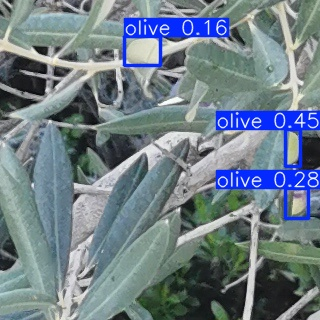

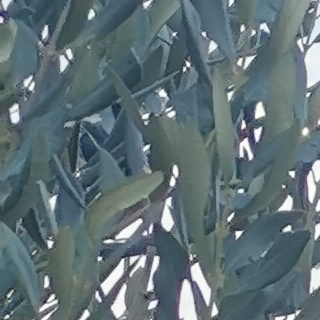

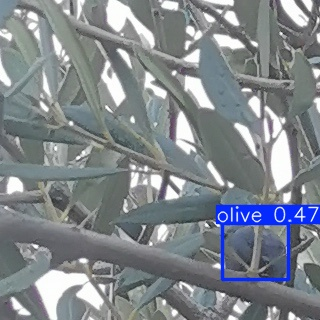

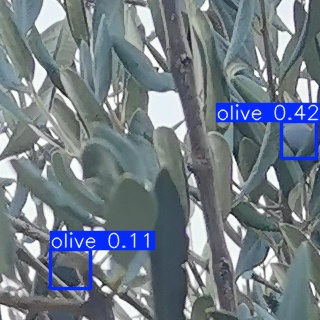

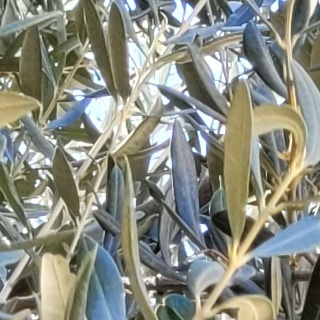

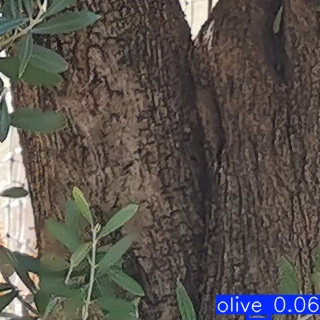

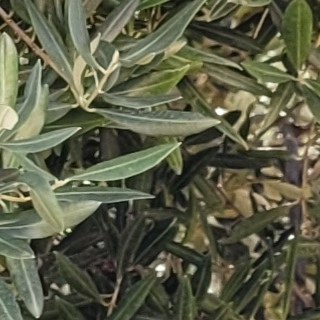

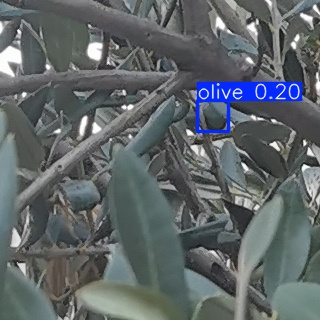

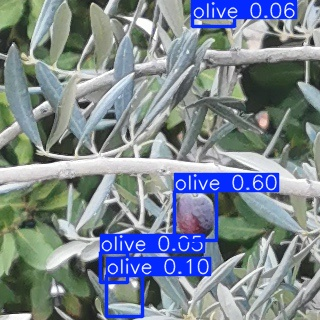

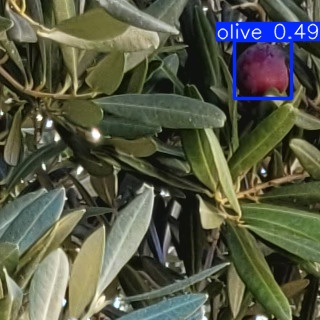

In [25]:
from IPython.display import Image, display
import glob

predictions = glob.glob('/content/runs/detect/predict/*.jpg')
for image_path in predictions[:10]:
    display(Image(filename=image_path, width=600))

# Télécharger le modèle

In [26]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

/content/my_model
  adding: my_model.pt (deflated 8%)
  adding: train/ (stored 0%)
  adding: train/train_batch16360.jpg (deflated 5%)
  adding: train/labels_correlogram.jpg (deflated 35%)
  adding: train/train_batch16362.jpg (deflated 4%)
  adding: train/P_curve.png (deflated 16%)
  adding: train/labels.jpg (deflated 23%)
  adding: train/val_batch0_pred.jpg (deflated 8%)
  adding: train/val_batch2_labels.jpg (deflated 11%)
  adding: train/val_batch2_pred.jpg (deflated 11%)
  adding: train/confusion_matrix.png (deflated 35%)
  adding: train/weights/ (stored 0%)
  adding: train/weights/last.pt (deflated 8%)
  adding: train/weights/best.pt (deflated 8%)
  adding: train/train_batch1.jpg (deflated 4%)
  adding: train/train_batch2.jpg (deflated 4%)
  adding: train/F1_curve.png (deflated 15%)
  adding: train/train_batch16361.jpg (deflated 4%)
  adding: train/train_batch0.jpg (deflated 3%)
  adding: train/val_batch0_labels.jpg (deflated 8%)
  adding: train/PR_curve.png (deflated 14%)
  adding: